In [73]:
from brian2 import *
import brian2.numpy_ as np
prefs.codegen.target = 'numpy'
start_scope()

#Conductances for all channels
C = 1*ufarad
IStim = 0*amp
gKmmax = 0.0006*siemens
gKdmax = 0.00045*siemens
gKdrmax = 0.01*siemens
gKamax = 0.07*siemens
gNamax = 0.04*siemens
gCaTmax = 0.001*siemens
gCaNmax = 0.001*siemens
gCaLmax = 0.001*siemens
gCaKmax = 0.0001*siemens
V0 = -65*mV
VK = -90*mV
VNa = 55*mV
temp = 34
Cai = 50 * nmole
Cao = 2 * mmole
#Parameters for the IKm channel
b0Km = 60*ms
vhalflKm = -40*mV
vhalftKm = -42*mV
shKm = 24*mV
klKm = -10*mV
a0tKm = 0.003/ms
zetatKm = 7
gmtKm = 0.4/mV
#Parameters for the IKd channel
vhalfmKd = -33*mV
zetamKd = 3/mV
shKd = 0*mV
a0nKd = 0.01/ms
gmnKd = 0.7
q10Kd = 1
tempKd = 34
#Parameters for the IKa channel
vhalfmKa = 11*mV
shKa = 24*mV
zetamKa = -1.5/mV
pwKa = -1/mV
tqKa = -40*mV
qqKa = 5*mV
gmnKa = 0.55
q10Ka = 5
a0nKa = 0.05/ms
#Parameters for the IKdr channel
gKdrmax = 0.01*siemens
zetamKdr = -3/mV
vhalfmKdr = 13*mV
shKdr = 24*mV
tempKdr = 34
q10Kdr = 1
gmnKdr = 0.7
a0nKdr = 0.01/ms
#Parameters for the CaT channel
q10CaT = 5
a0mCaT = 0.04/ms
a0hCaT = 0.015/ms
zetamCaT = 2/mV
zetahCaT = 3.5/mV
vhalfmCaT = -28*mV
vhalfhCaT = -75*mV
gmmCaT = 0.1
gmhCaT = 0.6
#Parameters for the CaN channel
q10CaN = 5
a0mCaN = 0.03/ms
zetamCaN = 2/mV
vhalfmCaN = -14*mV
gmmCaN = 0.1
f = ((25/293.15)*(temp + 273.15))*mV/2
kiCaN = 1*nmole
h2CaN = kiCaN/(kiCaN+Cai)
#Parameters for the CaL channel
KTF = ((25 / 293.15) * (temp + 273.15))
fCaL = KTF * mV / 2
kiCaL = 1 * nmole
h2CaL = kiCaL / (kiCaL + Cai)
q10CaL = 5
qtCaL = q10CaL ** ((temp - 25) / 10)
a0mCaL = 0.1
zetamCaL = 2/mV
vhalfmCaL = 4*mV
gmmCaL = 0.1
#Parameters for the CaK channel
d1 = 0.84
d2 = 1
kalp = 480*nmole
kbet = 130*pmole
abar = 0.28/ms
bbar = 0.48/ms
R = 8.314*joule/mole
far = 96485*amp*second/mole
#Parameters for the Na channel
vhalfsNa = -60*mV
a0sNa = 0.0003/ms
zetasNa = 12/mV
gmsNa = 0.2
q10Na = 2
temp = 34
Ra = 0.4/ms
Rb = 0.124/ms
Rg = 0.01/ms
Rd = 0.03/ms
tha = -30*mV
qa = 7.2*mV
qd = qg = 1.5*mV
shNa = 24*mV
thinf = -50*mV
qinf = 4*mV
thi1 = -45*mV
smax = 10*ms
vvh = -58*mV
vvs = 2*mV


#Global equations for parameters
@check_units(z=1, result=1)    
def efun(z):
    if (np.absolute(z) < 0.0001): 
        return 1 - z/2
    else:
        return z/(exp(z) - 1)
    
    
@check_units(V=volt, result=1)
def nu(V):
    return V / f


@check_units(V=volt, result=volt)
def ghk(V):
    return -f * (1 - (Cai / Cao) * exp(nu(V))) * efun(nu(V))


@check_units(V=volt, result=1)
def nuCaL(V):
    return V / fCaL


@check_units(V=volt, result=volt)
def ghkCaL(V):
    return -fCaL * (1 - (Cai / Cao) * exp(nu(V))) * efun(nu(V))


@check_units(k=mole, d=1, V=volt, result=mole)
def exp1(k, d, V):
    #return k * exp(-2 * d * far * V * (273.15 + temp) / R)
    return k*exp(-2*d*far*V/R/(273.15 + temp))


@check_units(V=volt, th=volt, a=Hz, q=volt, result=Hz*volt)
def trap0(V, th, a, q):
    if (abs(V-thi1) > 10**-6*mV):
        return a * (V - th) / (1 - exp(-(V - th)/q))
    else:
        return a * q


#General Structure for the equation
#I = INa + IKdr + IKa + ICaT + ICaN + ICaL + ICaK + IKm + IKd
#dV/dt = (IStim - INa - IKdr - IKa - ICaT - ICaN - ICaL - ICaK - IKm - IKd)/C
eqs = Equations('''

                    dV/dt = (I - IKm - IKd - IKa - IKdr - INa - ICaT - ICaN - ICaL - ICaK)/C : volt
                    #dV/dt = (IStim - IKm - IKd - IKa - IKdr)/C : volt
                    
                    #Equations for the IKm channel
                    IKm = gKmmax*mKm*(V-VK) : amp
                    dmKm/dt = (infKm - mKm)/tauKm : 1
                    infKm = (1/(1 + exp((V-vhalflKm-shKm)/(klKm)))) : 1
                    tauKm = b0Km + bettKm/(a0tKm*(1+alptKm)) : second
                    alptKm = exp(0.0378*(mV**-1)*zetatKm*(V-vhalftKm-shKm)) : 1
                    bettKm = exp(0.0378*zetatKm*gmtKm*(V-vhalftKm-shKm)) : 1
                    
                    #Equations for the IKd channel
                    IKd = gKd*(V-VK) : amp
                    gKd = gKdmax*mKd : siemens
                    dmKd/dt = (infmKd - mKd)/taumKd : 1
                    infmKd = 1/(1+alpmKd) : 1
                    taumKd = betmKd/(qtKd*a0nKd*(1+alpmKd)) : second
                    alpmKd = exp(0.001*zetamKd*(V-vhalfmKd-shKd)*96480/(8.315*(273.16 + temp))) : 1
                    betmKd = exp(0.001*zetamKd*gmnKd*(V-vhalfmKd-shKd)*96480/(8.315*(273.16 + temp))) : 1
                    qtKd = q10Kd**((temp - 24)/10) : 1
                    
                    #Equations for the IKa channel
                    IKa = gKa*(V-VK) : amp
                    gKa = gKamax*mKa : siemens
                    dmKa/dt = (infmKa - mKa)/taumKa : 1
                    infmKa = 1/(1 + alpmKa) : 1                    
                    zetaKa = zetamKa + pwKa/(1+exp((V-tqKa-shKa)/qqKa)) : 1/volt
                    taumKa = betmKa/(qtKa*a0nKa*(1+alpmKa)) : second
                    alpmKa = exp(0.001*zetaKa*(V-vhalfmKa-shKa)*96480/(8.315*(273.16+temp))) : 1
                    betmKa = exp(0.001*zetaKa*gmnKa*(V-vhalfmKa-shKa)*96480/(8.315*(273.16+temp))) : 1
                    qtKa = q10Ka**((temp-24)/10) : 1
                    
                    #Equations for the IKdr channel
                    IKdr = gKdr*(V-VK) : amp
                    gKdr = gKdrmax*mKdr : siemens
                    dmKdr/dt = (infmKdr - mKdr)/taumKdr : 1
                    infmKdr = 1/(1 + alpmKdr) : 1
                    taumKdr = betmKdr/(qtKdr*a0nKdr*(1 + alpmKdr)) : second
                    alpmKdr = exp(0.001*zetamKdr*(V-vhalfmKdr-shKdr)*96480/(8.315*(273.16 + temp))) : 1
                    betmKdr = exp(0.001*zetamKdr*gmnKdr*(V-vhalfmKdr-shKdr)*96480/(8.315*(273.16 + temp))) : 1
                    qtKdr = q10Kdr**((temp - 24)/10) : 1
                    
                    #Equations for the CaT channel
                    ICaT = gCaT*ghk(V) : amp (constant over dt)
                    gCaT = gCaTmax*mCaT*mCaT*hCaT : siemens
                    dmCaT/dt = (infmCaT - mCaT)/taumCaT : 1
                    dhCaT/dt = (infhCaT - hCaT)/tauhCaT : 1
                    infmCaT = alpmCaT/(alpmCaT+betmCaT) : 1
                    infhCaT = alphCaT/(alphCaT+bethCaT) : 1
                    alpmCaT = 0.2*(mV**-1)*(-V+19.26*mV)/(exp((-V+19.26*mV)/(10.0*mV))-1) : 1
                    alphCaT = 10**-6*exp(-V/(16.26*mV)) : 1
                    alpmtCaT = exp(0.0378*zetamCaT*(V-vhalfmCaT)) : 1
                    betmCaT = 0.009*exp(-V/(22.03*mV)) : 1
                    bethCaT = 1/(exp((-V+29.79*mV)/(10*mV))+1) : 1
                    betmtCaT = exp(0.0378*zetamCaT*gmmCaT*(V-vhalfmCaT)) : 1
                    taumCaT = betmtCaT/(qtCaT*a0mCaT*(1+alpmtCaT)) : second
                    tauhCaT = bethCaT/(a0hCaT*(1+alphCaT)) : second       
                    qtCaT = q10CaT ** ((temp - 25) / 10) : 1
                    
                    #Equations for the CaN channel
                    ICaN = gCaN*ghk(V) : amp (constant over dt)
                    gCaN = gCaNmax*mCaN*mCaN*hCaN*h2CaN : siemens
                    dmCaN/dt = (infmCaN - mCaN)/taumCaN : 1
                    dhCaN/dt = (infhCaN - hCaN)/tauhCaN : 1
                    infmCaN = alpmCaN*(1/alpmCaN+betmCaN) : 1
                    infhCaN = alphCaN*(1/alphCaN+bethCaN) : 1
                    taumCaN = betmtCaN/(qtCaN*a0mCaN*(1+alpmtCaN)) : second
                    tauhCaN = (1*ms/(alphCaN+bethCaN))/qtCaN : second
                    alpmCaN = 0.1967*(mV**-1)*(-V+19.88*mV)/(exp((-V+19.88*mV)/(10.0*mV))-1) : 1
                    alphCaN = 0.00016*exp(-V/(48.4*mV)) : 1
                    alpmtCaN = exp(0.0378*zetamCaN*(V-vhalfmCaN)) : 1 
                    betmCaN = 0.046*exp(-V/(20.73*mV)) : 1
                    bethCaN = 1/(exp((-V+39*mV)/(10*mV))+1) : 1
                    betmtCaN = exp(0.0378*zetamCaN*gmmCaN*(V-vhalfmCaN)) : 1
                    qtCaN = q10CaN ** ((temp - 25) / 10) : 1
                    
                    #Equations for the CaL channel
                    ICaL = gCaL*ghkCaL(V) : amp (constant over dt)
                    gCaL = gCaLmax*mCaL*mCaL*h2CaL : siemens
                    dmCaL/dt = (infmCaL - mCaL)/tauCaL : 1
                    infmCaL = alpCaL * 1/(alpCaL + betCaL) : 1
                    alpCaL = 15.69*(mV**-1)*(-V+81.5*mV)/(exp((-V+81.5*mV)/(10*mV))-1) : 1
                    betCaL = 0.29 * exp(-V/(10.86*mV)) : 1
                    tauCaL = betmtCaL*ms/(qtCaL*a0mCaL*(1+alpmtCaL)) : second 
                    alpmtCaL = exp(0.0378*zetamCaL*(V-vhalfmCaL)) : 1
                    betmtCaL = exp(0.0378*zetamCaL*gmmCaL*(V-vhalfmCaL)) : 1
                    
                    #Equations for the CaK channel
                    ICaK = gCaK*(V - VK) : amp            
                    gCaK = gCaKmax*oCaK : siemens
                    doCaK/dt = (infoCaK - oCaK)/tauCaK : 1
                    infoCaK = alpCaK*tauCaK : 1
                    tauCaK = 1/(alpCaK + betCaK) : second  
                    alpCaK = Cai*abar/(Cai + exp1(kalp, d1, V)) : Hz (constant over dt)
                    betCaK = bbar/(1 + Cai/exp1(kbet, d2, V)) : Hz (constant over dt)
                    
                    #Equations for the Na channel
                    INa = gNa*(V - VNa) : amp
                    gNa = gNamax*mNa*mNa*mNa*hNa*sNa : siemens
                    dmNa/dt = (infmNa - mNa)/taumNa : 1
                    dhNa/dt = (infhNa - hNa)/tauhNa : 1
                    dsNa/dt = (infsNa - sNa)/tausNa : 1
                    infmNa = a1/(a1 + b1) : 1 
                    infhNa = 1/(1 + exp((V-thinf-shNa)/qinf)) : 1
                    infsNa = alpvNa+(1-alpvNa) : 1
                    taumNa = 1/(a1 + b1)/qtNa : second 
                    tauhNa =  1/(a2 + b2)/qtNa : second 
                    tausNa = betsNa/(a0sNa*(1 + alpsNa)) : second
                    alpsNa = exp(0.001*zetasNa*(V-vhalfsNa-shNa)*96480/(8.315*(273.16 + temp))) : 1
                    alpvNa = 1/(1+exp((V-vvh-shNa)/vvs)) : 1
                    betsNa = exp(0.001*zetasNa*gmsNa*(V-vhalfsNa-shNa)*96480/(8.315*(273.16 + temp))) : 1
                    a1 = trap0(V,tha+shNa,Ra,qa) : Hz*volt (constant over dt)
                    b1 = trap0(-V,-tha-shNa,Rb,qa) : Hz*volt (constant over dt)
                    a2 = trap0(V,tha+shNa,Rd,qd) : Hz*volt (constant over dt)
                    b2 = trap0(-V,-tha-shNa,Rg,qg) : Hz*volt (constant over dt)
                    qtNa = (q10Na**((temp - 24)/10))/mV : 1/volt
                    I : amp
                    
                    ''')

#Initialization of a single neuron with the above equations.
group = NeuronGroup(1, eqs, threshold='V > -40*mV', refractory='V > -40*mV', method='exponential_euler')
#Attaching a state monitor to the neuron, records the voltage. If other equations should be recorded they can be added to 
#the array (e.g. ['V', 'I', 'INa']), each equation in the Equations() bracket can be tracked.
#For variables=True every variable is recorded which may use up a lot of memory.
M = StateMonitor(group, variables=True, record=True)
#Stores the configuration of the network
store()

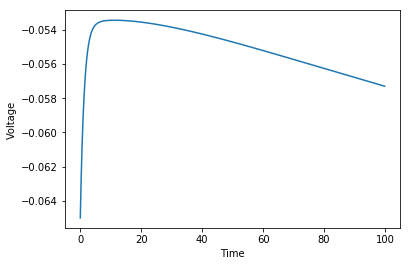

In [80]:
# Restore the original state of the network and initialize parameters
restore()
#Initialize Na channel parameters
alpv0 = 1/(1+exp((V0-vvh-shNa)/vvs))
mNa0 = trap0(V0,tha+shNa,Ra,qa)/(trap0(V0,tha+shNa,Ra,qa) + trap0(-V0,-tha-shNa,Rb,qa))
hNa0 = 1/(1 + exp((V0-thinf-shNa)/qinf))
sNa0 = alpv0+(1-alpv0)
group.mNa = mNa0
group.hNa = hNa0
group.sNa = sNa0
#Initialize Km channel parameters
mKm0 = (1/(1 + exp((V0-vhalflKm-shKm)/(klKm))))
group.mKm = mKm0
#Initialize Kd channel parameters
mKd0 = 1/(1+exp(0.001*zetamKd*(V0-vhalfmKd-shKd)*96480/(8.315*(273.16 + temp))))
group.mKd = mKd0
#Initialize Ka channel parameters
zetaKa0 = zetamKa + pwKa/(1+exp((V0-tqKa-shKa)/qqKa))
alpmKa0 = exp(0.001*zetaKa0*(V0-vhalfmKa-shKa)*96480/(8.315*(273.16+temp)))
mKa0 = 1/(1 + alpmKa0)
group.mKa = mKa0
#Initialize Kdr channel parameters
mKdr0 = 1/(1+exp(0.001*zetamKdr*(V0-vhalfmKdr-shKdr)*96480/(8.315*(273.16 + temp))))
group.mKdr = mKdr0
#Initialize CaT channel parameters
alpmCaT0 = 0.2*(mV**-1)*(-V0+19.26*mV)/(exp((-V0+19.26*mV)/(10.0*mV))-1)
betmCaT0 = 0.009*exp(-V0/(22.03*mV))
alphCaT0 = 10**-6*exp(-V0/(16.26*mV))
bethCaT0 = 1/(exp((-V0+29.79*mV)/(10*mV))+1)
mCaT0 = alpmCaT0/(alpmCaT0+betmCaT0)
hCaT0 = alphCaT0/(alphCaT0+bethCaT0)
group.mCaT = mCaT0
group.hCaT = hCaT0
#Initialize CaN channel parameters
alpmCaN0 = 0.1967*(mV**-1)*(-V0+19.88*mV)/(exp((-V0+19.88*mV)/(10*mV))-1)
alphCaN0 = 0.00016*exp(-V0/(48.4*mV))
betmCaN0 = 0.046*exp(65/20.73)
bethCaN0 = 1/(exp((-V0+39*mV)/(10*mV))+1)
mCaN0 = alpmCaN0*(1/alpmCaN0+betmCaN0)
hCaN0 = 0.00016*exp(-V0/(48.4*mV))*(1/0.00016*exp(-V0/(48.4*mV))+1/(exp((-V0+39*mV)/(10*mV))+1))
group.mCaN = mCaN0
group.hCaN = hCaN0
#Initialize CaL channel parameters
alpCaL0 = 15.69*(mV**-1)*(-V0+81.5*mV)/(exp((-V0+81.5*mV)/(10*mV))-1)
betCaL0 = 0.29 * exp(-V0/(10.86*mV))
mCaL0 = alpCaL0 * 1/(alpCaL0 + betCaL0)
group.mCaL = mCaL0
#Initialize CaK channel parameters
alpCaK0 = Cai*abar/(Cai + exp1(kalp, d1, V0))
betCaK0 = bbar/(1 + Cai/exp1(kbet, d2, V0))
tauCaK0 = 1/(alpCaK0 + betCaK0)
infoCaK0 = alpCaK0*tauCaK0
group.oCaK = infoCaK0
group.alpCaK = alpCaK0
group.betCaK = betCaK0
#Sets the initial voltage and stimulation current.
group.V = V0
group.I = 1000*nA
#Runs the neuron/network for the given duration
run(100*ms)
figure(1)
plot(M.t/ms, M.V[0])
xlabel('Time')
ylabel('Voltage')
show()